# Truncated Skewed Levy Distribution

In [2]:
from levy_distribution import pdf_from_cf, dump_levy, load_levy, histo_fit_levy, gs_fit_levy, kde_fit_levy, \
    kde_fit_levy_2
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import norm, gaussian_kde
import pandas as pd

In [9]:
mu = 0.0
c = 1
alpha = 1.76
lam = 0.08
beta = 0.99

## Evaluate at some points

In [10]:
x= [0.2, 2, -1]
pdf_from_cf(x,mu,c,alpha,lam,beta)

array([0.28343328, 0.15592783, 0.15635638])

## Make a plot
Takes around 4 seconds for 1000 points

It took 4.952970027923584 seconds for 1000 evaluations


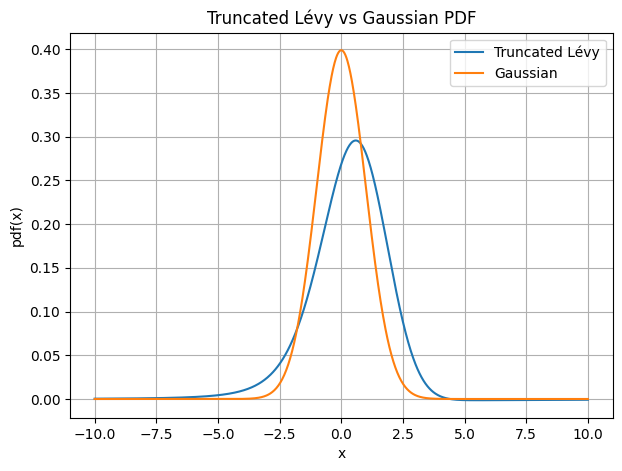

In [11]:
x_values = np.linspace(-10, 10, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, mu, c, alpha, lam, beta, k_max=15.0, ln_2_k_points=15, x_lim=250)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))
# It takes 4 seconds for 1000 evaluations

pdf_gaussian = norm.pdf(x_values, loc=mu, scale=c)
# Plot the resulting PDF:
plt.figure(figsize=(7, 5))
plt.plot(x_values, y_values, label='Truncated Lévy')
plt.plot(x_values, pdf_gaussian, label='Gaussian')

plt.title("Truncated Lévy vs Gaussian PDF")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.legend()
plt.grid(True)
plt.show()

## Dump the data points to a file
Takes 40 seconds for 10000 points

In [ ]:
path = dump_levy(mu,c,alpha, lam, beta, x_min=-15, x_max=15, x_points=10000, filename='data/my_levy', k_max=15, ln_2_k_points=12)

## Reload the saved data points
This will give a scipy.stats distribution for the fixed parameters, which allows for various operations, like evaluating moments and also sampling

In [ ]:
filename = 'data/my_levy_' + str(np.round(mu,2)) + '_' +  str(np.round(c,2)) + '_' +   str(np.round(alpha,2)) + '_' +   str(np.round(lam,2)) + '_' +   str(np.round(beta,2))+'.npz'

my_levy = load_levy('data/my_levy_0.0_1_0.67_0.84_-0.28.npz')

Sample from the distribution, and plot the histogram

In [ ]:
sample = my_levy.rvs(size = 1000)

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(sample, bins=30, density=True)
plt.plot(x_values, y_values, label='Truncated Lévy')
plt.title("Truncated Lévy")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.legend()
plt.show()

## Real data

In [ ]:
dfs = pd.read_excel('../Indices_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]
snp500 = dfs['S&P500'][['Date', 'Close']][18000:]
data = snp500.copy()
data = data[(data['Date'] > '2006-01-01') & (data['Date'] < '2017-12-31')]

data['Returns'] = data['Close'].pct_change()
data['10 Days Returns'] = data['Returns'].rolling(window=10).sum()
data['210 Days Returns'] = data['Returns'].rolling(window=210).sum()
data = data.iloc[210:]

std_dev = data['Returns'].std()
mean = data['Returns'].mean()
data['Scaled Returns'] = (data['Returns']-mean)/std_dev

data['10 Days Sum Scaled Returns']=data['Scaled Returns'].rolling(window=10).sum()

std_dev_10 = data['10 Days Returns'].std()
mean_10 = data['10 Days Returns'].mean()
data['10 Days Scaled Returns'] = (data['10 Days Returns']-mean_10)/std_dev_10

std_dev_210 = data['210 Days Returns'].std()
mean_210 = data['210 Days Returns'].mean()
data['210 Days Scaled Returns'] = (data['210 Days Returns']-mean_10)/std_dev_210


In [ ]:
print(data['10 Days Returns'])

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(data['Scaled Returns'], range=(-5, 5), bins=30, density=True, color='green')
plt.hist(sample,range=(-5, 5), bins=30, density=True, alpha=0.5, color='red')
plt.plot(x_values, y_values, label='Truncated Lévy', color='red')
plt.title("Truncated Lévy: " + str(np.round(mu,2)) + ' ' +  str(np.round(c,2)) + ' ' +   str(np.round(alpha,2)) + ' ' +   str(np.round(lam,2)) + ' ' +   str(np.round(beta,2))
)
plt.show()

## Histo Fit the PDF

In [ ]:
n_points = 7
alpha_grid = np.linspace(0.69,0.81,n_points)
lam_grid = np.linspace(1.60,1.90,n_points)
beta_grid = np.linspace(-0.19,-0.23,n_points)

In [ ]:
opt = histo_fit_levy(data['Scaled Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid , n_bins = 30, k_max=15.0, ln_2_k_points=12)

In [ ]:
x_values = np.linspace(-5, 5, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, 0, 1, opt[0], opt[1], opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(data['Scaled Returns'], range=(-5, 5), bins=30, density=True, color='green')
plt.plot(x_values, y_values, label='Truncated Lévy', color='red')
plt.title("Truncated Lévy: " + str(np.round(0,2)) + ' ' +  str(np.round(1,2)) + ' ' +   str(np.round(opt[0],3)) + ' ' +   str(np.round(opt[1],3)) + ' ' +   str(np.round(opt[2],3))
)
plt.show()

## KDE Fit the PDF
On the standardized normal

In [ ]:
n_points = 7
alpha_grid = np.linspace(0.69,0.81,n_points)
lam_grid = np.linspace(1.60,1.90,n_points)
beta_grid = np.linspace(-0.19,-0.23,n_points)

In [ ]:
kde_opt = kde_fit_levy(data['Scaled Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 100, x_max=15, k_max=15.0, ln_2_k_points=12)

In [ ]:
print(kde_opt)

In [ ]:
x_values = np.linspace(-10, 10, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, 0, 1, kde_opt[0], kde_opt[1], kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

kde=gaussian_kde(data['Scaled Returns'])
y_kde = kde(x_values)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.hist(data['Scaled Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standarized Returns')
ax.plot(x_values, y_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_values, y_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)

ax.legend()
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
#sns.despine(ax=ax, left=True, bottom=True)

ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(kde_opt[0],2)) + ' ' +   str(np.round(kde_opt[1],2)) + ' ' +   str(np.round(kde_opt[2],2)))

plt.show()

## Scale the PDF on 10 days sum of std returns

In [ ]:
scaling = 10**(1/kde_opt[0])
print(scaling)

In [ ]:
x_values_10d = np.linspace(-scaling, scaling, 1000)
y_values_10d = pdf_from_cf(x_values_10d/scaling, 0, 1, kde_opt[0], kde_opt[1]*scaling, kde_opt[2], k_max=50.0, ln_2_k_points=12, x_lim=25)/scaling


In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.hist(data['10 Days Sum Scaled Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 10d sum Standarized Returns')
ax.plot(x_values_10d, y_values_10d, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)

ax.legend()
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
#sns.despine(ax=ax, left=True, bottom=True)

ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(kde_opt[0],2)) + ' ' +   str(np.round(kde_opt[1],2)) + ' ' +   str(np.round(kde_opt[2],2)))

plt.show()

## Fit on real data

In [ ]:
mean = data['Returns'].mean()
std_dev = data['Returns'].std()

print(mean, std_dev)

In [ ]:

n_points = 5
mu_grid = np.linspace(0.000314, 0.000314,n_points)
c_grid = np.linspace(0.0008, 0.0018,n_points)
alpha_grid = np.linspace(0.3,0.81,n_points)
lam_grid = np.linspace(0.01,5.00,n_points)
beta_grid = np.linspace(-0.19,-0.23,n_points)

In [ ]:
kde_opt = kde_fit_levy_2(data['Returns'],mu_grid = mu_grid, c_grid=c_grid,alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 100, x_max=30, k_max=50.0, ln_2_k_points=12)

In [ ]:
print(kde_opt)

In [ ]:
x_real = np.linspace(-0.2, 0.2, 1000)
y_real = pdf_from_cf(x_real, 0, 1, kde_opt[0], kde_opt[1]*scaling, kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.hist(data['Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standarized Returns')
ax.plot(x_real, y_real, label='10-days Scaled Truncated Lévy', color='green', linewidth=1.75)
plt.show()

In [ ]:
x_values = np.linspace(-0.1, 0.1, 1000)
scaling = std_dev**(1/kde_opt[0])
y_scaled = pdf_from_cf(x_values, 0, 1 * scaling, kde_opt[0], kde_opt[1] * scaling, kde_opt[2], k_max=50.0,
                       ln_2_k_points=15, x_lim=100)
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.hist(data['Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standarized Returns')
ax.plot(x_values, y_scaled, label='10-days Scaled Truncated Lévy', color='green', linewidth=1.75)
plt.show()